In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
def fetch_data(file_path):
    data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    return data

In [3]:
# create def for portfolio optimization
def optimize_portfolio(data):
    # expected returns -> historical data
    mu = mean_historical_return(data)
    # calculate covariance matrix
    S = CovarianceShrinkage(data).ledoit_wolf()
    # initialize efficient frontier obj
    ef = EfficientFrontier(mu, S)
    # get weights
    weights = ef.max_sharpe()
    # clean weights
    cleaned_weights = ef.clean_weights()
    # get performance
    ef.portfolio_performance(verbose=True) # return [expect return, vola, sharpe ratio]
    
    sharpe_ratio = ef.portfolio_performance()[2]
    # categorize sharpe ratio; the higher the better
    if sharpe_ratio > 3.0:
        sharpe_evaluation = 'Exceptional'
    elif sharpe_ratio > 2.0:
        sharpe_evaluation = 'Excellent'
    elif sharpe_ratio > 1.0:
        sharpe_evaluation = 'Good'
    else:
        sharpe_evaluation = 'Suboptimal'
    
    print(f'\nSharpe Ratio Eval: {sharpe_evaluation}')

    return cleaned_weights, mu, S

In [4]:
# create discrete allocations
def calculate_allocation(weights, data, total_portfolio_value):
    # fetch latest price
    latest_prices= get_latest_prices(data)
    # initialize the allocation obj with weights and portfolio value
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=total_portfolio_value)
    # calculate the number of shares and leftover cash
    allocation, leftover = da.lp_portfolio()

    return allocation, leftover, latest_prices

In [18]:
# create a plot for visually checking the results
def plot_results(weights, mu):
    plt.figure(figsize=(10, 5))
    plt.style.use('dark_background')
    plt.bar(weights.keys(), weights.values(), color='cyan')
    plt.xlabel('Asset')
    plt.ylabel('Weights')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.title('Optimized Portfolio Weights', color='white')
    #plt.xticks(color='black')
    #plt.yticks(color='black')
    plt.show()

                  AAPL        AMZN        GOOG        META        MSFT  \
Date                                                                     
2020-03-30   61.837044   98.197502   57.070686  165.171524  153.368729   
2020-03-31   61.710846   97.486000   57.866421  166.017548  150.956680   
2020-04-01   58.463806   95.385002   55.020397  158.851334  145.596466   
2020-04-02   59.439369   95.941498   55.777809  157.447937  148.611557   
2020-04-03   58.585136   95.329498   54.635223  153.456757  147.242783   
...                ...         ...         ...         ...         ...   
2025-03-24  220.729996  203.259995  169.929993  618.849976  393.079987   
2025-03-25  223.750000  205.710007  172.789993  626.309998  395.160004   
2025-03-26  221.529999  201.130005  167.139999  610.979980  389.970001   
2025-03-27  223.850006  201.360001  164.080002  602.580017  390.579987   
2025-03-28  217.899994  192.720001  156.059998  576.739990  378.799988   

                  NVDA        TSLA  


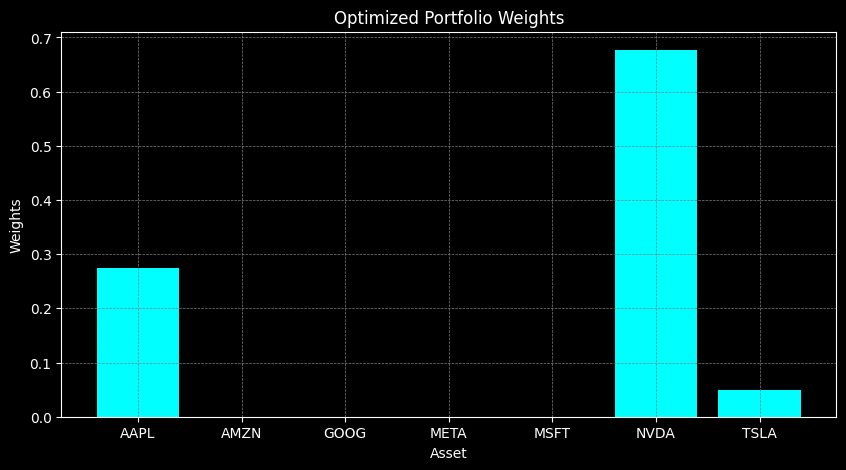

In [19]:
#execute
# get stock data
file_path = './stocks.csv'
data = fetch_data(file_path)

print(data)

# optimize portfolio
weights, mu, S = optimize_portfolio(data)

# total portfolio value
total_portfolio_value = 10000

allocation, leftover, latest_prices = calculate_allocation(weights, data, total_portfolio_value)

print('\nOptimized weights:')
print(weights)

#print discrete allocation for stocks
print('\nDiscrete allocations:')
for stock, shares in allocation.items():
    cost_per_share = latest_prices[stock]
    total_cost = shares * cost_per_share
    print(f'{stock}: {shares} shares, Total cost: {total_cost:.2f}')

print(f'\nLeftover Cash: ${leftover:.2f}')

# plot
plot_results(weights, mu)